In [242]:
import datetime
import math

In [162]:
import matplotlib.pyplot as plt

In [253]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm

In [29]:
df = pd.read_excel('online_retail_data.xlsx')
print(df.shape)
df.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [517]:
# create a copy of the dataframe so the excel file doesn't have to be read again
df_copy = df.copy()

# Data Discovery

- 4372 Unique CustomerID values
- 25900 Unique InvoiceNo values
- 4070 Unique StockCode values
- 38970 max unit price
- 0.03 min unit price
- 9,287 returns
- date range is (2010-12-01 to 2011-12-09)

In [593]:
df = df[df['InvoiceDate'] <= '2011-12-01 23:59:59']

In [594]:
df[df.StockCode == 'B']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalRevenue,DaysSincePurchase


In [595]:
df = df[df.StockCode != 'B']

A few items that are less than 0.01 and the quantity doesn't bring them to 0.01 will also be dropped

In [596]:
df = df[df.UnitPrice > .01]

In [597]:
df['TotalRevenue'] = df['Quantity'] * df['UnitPrice']
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalRevenue,DaysSincePurchase
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


### Creating a dataframe of customers, their total revenue, number of invoices during the timeframe and time since last purchase

In [598]:
grouped_customers = df.groupby(['CustomerID', 'InvoiceNo']).sum()

In [599]:
invoice_count = df.groupby(['CustomerID'], as_index=False)['InvoiceNo'].count()

In [600]:
customer_total_revenue = df.groupby(['CustomerID'], as_index=False)['TotalRevenue'].sum()

In [601]:
customer_total_revenue.TotalRevenue = round(customer_total_revenue.TotalRevenue, 2)

In [602]:
customer_total_revenue_invoice_count = customer_total_revenue.merge(invoice_count, on='CustomerID', sort=True)

In [603]:
customer_total_revenue_invoice_count = customer_total_revenue_invoice_count[customer_total_revenue_invoice_count['TotalRevenue'] > 0]

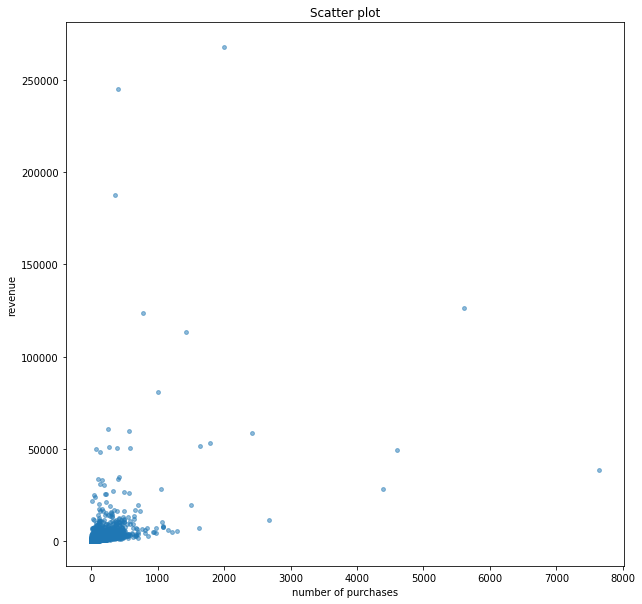

In [604]:
plt.figure(figsize=(10,10))
plt.scatter(customer_total_revenue_invoice_count.InvoiceNo, customer_total_revenue_invoice_count.TotalRevenue, s=15, alpha=0.5)
plt.title('Scatter plot')
plt.xlabel('number of purchases')
plt.ylabel('revenue')
plt.show()


Creating a column in the original dataframe that marks how long ago from the last possibe date an item was puchased

In [605]:
df['DaysSincePurchase'] = df['InvoiceDate'].max() - df['InvoiceDate']

In [606]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalRevenue,DaysSincePurchase
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,365 days 11:28:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,365 days 11:28:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,365 days 11:28:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,365 days 11:28:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,365 days 11:28:00


Identifying the most recent purchase and setting that in a new dataframe, then merging that into the rest of the data

In [607]:
customer_since_purchase = df.groupby(['CustomerID'], as_index=False)['DaysSincePurchase'].min()

In [609]:
customer_total_revenue_invoice_count_since_purchase = customer_total_revenue_invoice_count.merge(customer_since_purchase, on='CustomerID', sort=True)

In [610]:
customer_total_revenue_invoice_count_since_purchase.head(2)

,CustomerID,TotalRevenue,InvoiceNo,DaysSincePurchase
0,12347.0,4085.18,171,31 days 07:29:00
1,12348.0,1797.24,31,67 days 06:41:00


DaysSinceLastPurchase is timedelta64, in order to make it work for creating plots, it has to be made into an integer

In [611]:
RecentPurchase = customer_total_revenue_invoice_count_since_purchase['DaysSincePurchase']

In [631]:
RecentPurchaseDays = [None] * len(RecentPurchase)

In [632]:
for i in range(len(RecentPurchase)):
    RecentPurchaseDays[i] = (RecentPurchase[i].days)

In [643]:
RecentPurchase[i]

Timedelta('34 days 10:25:00')

In [633]:
len(customer_total_revenue_invoice_count_since_purchase)

4280

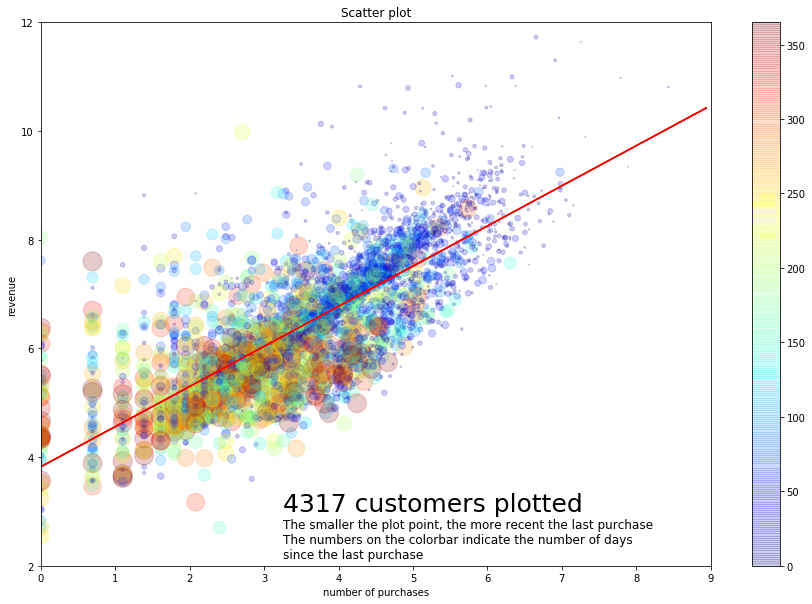

In [644]:
fit = np.polyfit(np.log(customer_total_revenue_invoice_count_since_purchase.InvoiceNo),
                 np.log(customer_total_revenue_invoice_count_since_purchase.TotalRevenue),1)
fit_fn = np.poly1d(fit) 

plt.figure(figsize=(15,10))
plt.scatter(np.log(customer_total_revenue_invoice_count_since_purchase.InvoiceNo), 
            np.log(customer_total_revenue_invoice_count_since_purchase.TotalRevenue), 
            s=RecentPurchaseDays, alpha=0.2, c=RecentPurchaseDays,cmap="jet")
plt.plot(np.log(customer_total_revenue_invoice_count_since_purchase.InvoiceNo), fit_fn(np.log(customer_total_revenue_invoice_count_since_purchase.InvoiceNo)), 'red')
plt.title('Scatter plot')
plt.xlabel('number of purchases')
plt.ylabel('revenue')
plt.xlim(0,9)
plt.ylim(2,12)
plt.colorbar()
plt.text(3.25, 3, '4317 customers plotted', fontsize=25)
plt.text(3.25, 2.15, 'The smaller the plot point, the more recent the last purchase\nThe numbers on the colorbar indicate the number of days\nsince the last purchase', fontsize=12)
plt.show()
plt.close()


Creating a loop to make an animated gif of the plot to better understand it

In [565]:
# i = 4317
for i in range(1, len(customer_total_revenue_invoice_count_since_purchase)):
    if i % 25 == 0 or i == 4317:
        fit = np.polyfit(np.log(customer_total_revenue_invoice_count_since_purchase.InvoiceNo[0:i]),np.log(customer_total_revenue_invoice_count_since_purchase.TotalRevenue[0:i]),1)
        fit_fn = np.poly1d(fit) 

        plt.figure(figsize=(15,10))
        plt.scatter(np.log(customer_total_revenue_invoice_count_since_purchase.InvoiceNo[0:i]), 
                    np.log(customer_total_revenue_invoice_count_since_purchase.TotalRevenue[0:i]), 
                    s=RecentPurchaseDays[0:i], alpha=0.2, c=RecentPurchaseDays[0:i],cmap="jet")
        plt.plot(np.log(customer_total_revenue_invoice_count_since_purchase.InvoiceNo[0:i]), fit_fn(np.log(customer_total_revenue_invoice_count_since_purchase.InvoiceNo[0:i])), 'red')
        plt.title('Scatter plot')
        plt.xlabel('number of purchases')
        plt.ylabel('revenue')
        plt.xlim(0,9)
        plt.ylim(2,12)
        plt.colorbar()
        plt.text(3.25, 3, str(i) + ' observations', fontsize=25)
        plt.text(3.25, 2.15, 'The larger the plot point, the more recent the last purchase\nThe numbers on the colorbar indicate the number of days\nfrom the start to the last purchase made', fontsize=12)
        plt.savefig('log_img/' + str(i) + '.png')
        plt.close()


In [566]:
i = 4317
fit = np.polyfit(np.log(customer_total_revenue_invoice_count_since_purchase.InvoiceNo[0:i]),np.log(customer_total_revenue_invoice_count_since_purchase.TotalRevenue[0:i]),1)
fit_fn = np.poly1d(fit) 

plt.figure(figsize=(15,10))
plt.scatter(np.log(customer_total_revenue_invoice_count_since_purchase.InvoiceNo[0:i]), 
            np.log(customer_total_revenue_invoice_count_since_purchase.TotalRevenue[0:i]), 
            s=RecentPurchaseDays[0:i], alpha=0.2, c=RecentPurchaseDays[0:i],cmap="jet")
plt.plot(np.log(customer_total_revenue_invoice_count_since_purchase.InvoiceNo[0:i]), fit_fn(np.log(customer_total_revenue_invoice_count_since_purchase.InvoiceNo[0:i])), 'red')
plt.title('Scatter plot')
plt.xlabel('number of purchases')
plt.ylabel('revenue')
plt.xlim(0,9)
plt.ylim(2,12)
plt.colorbar()
plt.text(3.25, 3, str(i) + ' observations', fontsize=25)
plt.text(3.25, 2.15, 'The larger the plot point, the more recent the last purchase\nThe numbers on the colorbar indicate the number of days\nfrom the start to the last purchase made', fontsize=12)
plt.savefig('log_img/' + str(i) + '.png')
plt.close()


In [579]:
# i = 4317
for i in range(1, len(customer_total_revenue_invoice_count_since_purchase)):
    if i % 25 == 0 or i == 4317:
        fit = np.polyfit(customer_total_revenue_invoice_count_since_purchase.InvoiceNo[0:i],customer_total_revenue_invoice_count_since_purchase.TotalRevenue[0:i],1)
        fit_fn = np.poly1d(fit) 

        plt.figure(figsize=(15,10))
        plt.scatter(customer_total_revenue_invoice_count_since_purchase.InvoiceNo[0:i], 
                    customer_total_revenue_invoice_count_since_purchase.TotalRevenue[0:i], 
                    s=RecentPurchaseDays[0:i], alpha=0.2, c=RecentPurchaseDays[0:i],cmap="jet")
        plt.plot(customer_total_revenue_invoice_count_since_purchase.InvoiceNo[0:i], fit_fn(customer_total_revenue_invoice_count_since_purchase.InvoiceNo[0:i]), 'red')
        plt.title('Scatter plot')
        plt.xlabel('number of purchases')
        plt.ylabel('revenue')
        plt.xlim(0,8000)
        plt.ylim(0,200000)
        plt.text(3000, 26000, str(i) + ' observations', fontsize=25)
        plt.text(3000, 9000, 'The larger the plot point, the more recent the last purchase\nThe numbers on the colorbar indicate the number of days\nfrom the start to the last purchase made', fontsize=12)
        plt.colorbar()
        plt.savefig('non_log_img/' + str(i) + '.png')
        plt.close()


i = 4317
fit = np.polyfit(customer_total_revenue_invoice_count_since_purchase.InvoiceNo[0:i],customer_total_revenue_invoice_count_since_purchase.TotalRevenue[0:i],1)
fit_fn = np.poly1d(fit) 

plt.figure(figsize=(15,10))
plt.scatter(customer_total_revenue_invoice_count_since_purchase.InvoiceNo[0:i], 
            customer_total_revenue_invoice_count_since_purchase.TotalRevenue[0:i], 
            s=RecentPurchaseDays[0:i], alpha=0.2, c=RecentPurchaseDays[0:i],cmap="jet")
plt.plot(np.log(customer_total_revenue_invoice_count_since_purchase.InvoiceNo[0:i]), fit_fn(np.log(customer_total_revenue_invoice_count_since_purchase.InvoiceNo[0:i])), 'red')
plt.title('Scatter plot')
plt.xlabel('number of purchases')
plt.ylabel('revenue')
plt.colorbar()
plt.xlim(0,8000)
plt.ylim(0,200000)
plt.text(3000, 26000, str(i) + ' observations', fontsize=25)
plt.text(3000, 9000, 'The larger the plot point, the more recent the last purchase\nThe numbers on the colorbar indicate the number of days\nfrom the start to the last purchase made', fontsize=12)
plt.savefig('non_log_img/' + str(i) + '.png')
plt.close()


In [645]:
customer_total_revenue_invoice_count_since_purchase['SinceLastPurchase'] = RecentPurchaseDays

In [646]:
customer_total_revenue_invoice_count_since_purchase.head(5)

,CustomerID,TotalRevenue,InvoiceNo,DaysSincePurchase,SinceLastPurchase
0,12347.0,4085.18,171,31 days 07:29:00,31
1,12348.0,1797.24,31,67 days 06:41:00,67
2,12349.0,1757.55,73,10 days 10:03:00,10
3,12350.0,334.40,17,302 days 03:53:00,302
4,12352.0,1545.41,95,28 days 05:17:00,28


# There are a series of purchases with no customer number

In [487]:
df_no_customer = df[df['CustomerID'].isna()]

In [489]:
df_no_customer.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalRevenue,DaysSincePurchase
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom,2.51,372 days 22:18:00
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom,5.02,372 days 22:18:00


### Grouping the invoices without customers into a separate dataframe to better understand the data

This is simply to explore the data, since customers are a part of our target, this data has to be set aside.

In [618]:
no_customer_quantity = df_no_customer.groupby(['InvoiceNo'], as_index=False)['Quantity'].sum()

In [619]:
no_customer_revenue = df_no_customer.groupby(['InvoiceNo'], as_index=False)['TotalRevenue'].sum()

In [620]:
no_customer_revenue.describe()

,TotalRevenue
count,1609.000000
mean,906.615401
std,2891.566878
min,-17836.460000
25%,8.250000
50%,257.400000
75%,1464.520000
max,52940.940000


In [621]:
no_customer_df_by_invoice = no_customer_quantity.merge(no_customer_revenue, on='InvoiceNo', sort=True)

In [622]:
len(no_customer_df_by_invoice)

1609

/Users/robblatt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  
/Users/robblatt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


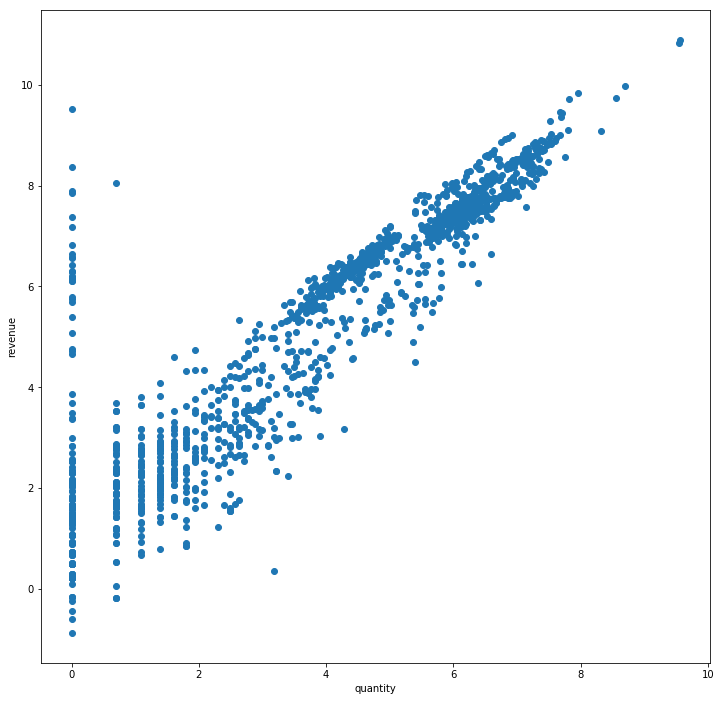

In [623]:
    plt.figure(figsize=(12,12))
    plt.scatter(np.log(no_customer_df_by_invoice.Quantity), 
                np.log(no_customer_df_by_invoice.TotalRevenue))
#     plt.title('Non-log transformed')
    plt.xlabel('quantity')
    plt.ylabel('revenue')
#     plt.xlim(0,8000)
#     plt.ylim(0,30000)
#     plt.text(4000, 1000, str(i) + ' observations', fontsize=60)
    plt.show()
#     plt.close()

# Clustering

In [586]:
from sklearn.datasets import make_moons
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KernelDensity
np.random.seed(0)

In [589]:
agg_clust = AgglomerativeClustering(n_clusters=3)
agg_clust
assigned_clust = agg_clust.fit_predict(customer_total_revenue_invoice_count_since_purchase.InvoiceNo)


ValueError: Expected 2D array, got 1D array instead:
array=[182  31  73 ...  13 756  70].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.